In [2]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('test_data.csv')

In [4]:
drop_columns = ['Account_ID', 'Entity_ID',
       'Closure_Type', 'Entity_City', 'Entity_State', 'Entity_Zip',
         'Total_Paid', 'Number_of_payments',
       'Percent_Paid', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s',
       'age_70s', 'age_over_80','Target','Creditor_Name']

In [5]:
data.drop(drop_columns, axis=1, inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
Seller_Type                   100000 non-null object
Median_Household_Income       100000 non-null float64
Invoice_bal                   100000 non-null float64
Age                           100000 non-null float64
Income_level                  100000 non-null object
Age_MedIncome                 100000 non-null float64
Invbal_MedIncome              100000 non-null float64
Invbal_Age                    100000 non-null float64
Paid                          100000 non-null int64
unemployment_rate             97912 non-null float64
labor_force_participation     97969 non-null float64
education_highschool          97964 non-null float64
education_college_or_above    97964 non-null float64
home_value                    96886 non-null float64
rent_burden                   95890 non-null float64
Age_range                     100000 non-null object
Unemply_rate_range            100000 

### Converting objects to category datatypes & One-hot-encode our categorical data

In [7]:
# #selecting data types "object" in order to one hot encode
categorical = data.loc[:, (data.dtypes == np.object) | (data.dtypes == np.int64)]

#converting data types to "category"
for col in categorical.columns: 
    categorical[col] = categorical[col].astype('category')

In [8]:
target = categorical.Paid

cat_features = categorical.drop('Paid', axis=1)
one_hot_cat = pd.get_dummies(cat_features)

### Standard scaling our numerical data

In [9]:
from sklearn.preprocessing import StandardScaler, RobustScaler

#RobustScaler is less prone to outliers 

std_scl = StandardScaler()
rob_scl = RobustScaler()

In [10]:
#selecting data types "float"
numerical = data.loc[:, data.dtypes == np.float64]

In [11]:
numerical['scl_Median_Household_Income'] = rob_scl.fit_transform(numerical.Median_Household_Income.values.reshape(-1,1))
numerical['scl_Invoice_bal'] = rob_scl.fit_transform(numerical.Invoice_bal.values.reshape(-1,1))
numerical['scl_Age'] = rob_scl.fit_transform(numerical.Age.values.reshape(-1,1))
numerical['scl_Age_MedIncome'] = rob_scl.fit_transform(numerical.Age_MedIncome.values.reshape(-1,1))
numerical['scl_Unemployment_rate'] = rob_scl.fit_transform(numerical.unemployment_rate.values.reshape(-1,1))
numerical['scl_Labor_force_participation'] = rob_scl.fit_transform(numerical.labor_force_participation.values.reshape(-1,1))
numerical['scl_Education_Highschool'] = rob_scl.fit_transform(numerical.education_highschool.values.reshape(-1,1))
numerical['scl_Education_College'] = rob_scl.fit_transform(numerical.education_college_or_above.values.reshape(-1,1))
numerical['scl_Home_value'] = rob_scl.fit_transform(numerical.home_value.values.reshape(-1,1))
numerical['scl_Rent_burden'] = rob_scl.fit_transform(numerical.rent_burden.values.reshape(-1,1))

In [12]:
num_drop = ['Median_Household_Income', 'Invoice_bal', 'Age', 'Age_MedIncome',
       'Invbal_MedIncome', 'Invbal_Age', 'unemployment_rate',
       'labor_force_participation', 'education_highschool',
       'education_college_or_above', 'home_value', 'rent_burden']

scaled_num = numerical.drop(num_drop, axis=1)
scaled_num.columns

Index(['scl_Median_Household_Income', 'scl_Invoice_bal', 'scl_Age',
       'scl_Age_MedIncome', 'scl_Unemployment_rate',
       'scl_Labor_force_participation', 'scl_Education_Highschool',
       'scl_Education_College', 'scl_Home_value', 'scl_Rent_burden'],
      dtype='object')

In [13]:
#combining numerical and categorical features into one dataset to scale
c = pd.concat([target, one_hot_cat], axis=1, join_axes=[target.index])
#filling NaNs with 0s
c.fillna(0, inplace=True)

In [14]:
c.head()

,Paid,Seller_Type_AMBULANCE,Seller_Type_HOSPITAL,Income_level_0ver_150k,Income_level_100k_to_150k,Income_level_20k_to_25k,Income_level_25k_to_35k,Income_level_35k_to_50k,Income_level_50k_to_75k,Income_level_75k_to_100k,...,Education_highschool_30-35%,Education_highschool_35-40%,Education_highschool_40-45%,Education_highschool_45-50%,Education_highschool_5-10%,Education_highschool_50-55%,Education_highschool_55-60%,Education_highschool_60-65%,Education_highschool_65-70%,Education_highschool_70%+
0,1,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
#combining numerical and categorical features into one dataset to scale
new_df = pd.concat([c, scaled_num], axis=1, join_axes=[c.index])
new_df.fillna(0, inplace=True)

## Random Under-sampling

In [17]:
sample_df = new_df.sample(frac=.3)

payers = sample_df.loc[new_df.Paid ==1]
nonpayers = sample_df.loc[new_df.Paid == 0] 

norm_dist_df = pd.concat([payers, nonpayers])

In [18]:
df = norm_dist_df.sample(10000, random_state=123)
df.Paid.value_counts(normalize=True)

1    0.5103
0    0.4897
Name: Paid, dtype: float64

In [19]:
df.head()

,Paid,Seller_Type_AMBULANCE,Seller_Type_HOSPITAL,Income_level_0ver_150k,Income_level_100k_to_150k,Income_level_20k_to_25k,Income_level_25k_to_35k,Income_level_35k_to_50k,Income_level_50k_to_75k,Income_level_75k_to_100k,...,scl_Median_Household_Income,scl_Invoice_bal,scl_Age,scl_Age_MedIncome,scl_Unemployment_rate,scl_Labor_force_participation,scl_Education_Highschool,scl_Education_College,scl_Home_value,scl_Rent_burden
91723,0,0,1,0,0,0,0,0,1,0,...,1.156850,4.045259,0.733880,1.428178,0.250000,0.803922,-1.234234,1.233333,0.358769,-0.221053
83678,0,0,1,0,0,0,0,1,0,0,...,-0.375677,1.961639,-0.129757,-0.212839,-0.477273,0.686275,-0.783784,1.238889,0.618839,-1.052632
63490,0,0,1,0,0,0,0,1,0,0,...,-0.647565,1.360149,-0.720666,-0.754458,-0.318182,-0.637255,0.684685,-0.450000,-0.518839,-0.115789
49670,1,0,1,0,0,0,0,0,1,0,...,0.217219,-0.337356,-0.857030,-0.596345,-0.931818,0.715686,-1.909910,2.805556,1.762311,-1.084211
16694,1,0,1,0,0,0,0,0,1,0,...,-0.000665,-0.283054,-0.311575,-0.197715,-0.295455,0.852941,-0.693694,0.733333,0.679312,0.010526


In [44]:
drp = ['Paid','scl_Median_Household_Income', 'scl_Invoice_bal', 'scl_Age',
       'scl_Age_MedIncome', 'scl_Unemployment_rate',
       'scl_Labor_force_participation', 'scl_Education_Highschool',
       'scl_Education_College', 'scl_Home_value', 'scl_Rent_burden', 'Seller_Type_AMBULANCE', 'Seller_Type_HOSPITAL']

In [45]:
#creating features to feed into predictors 
features = df.drop(drp, axis=1, inplace=False)
#creating target variable (y)
target = df.Paid 
#creating dummies, one-hot encode prior to standardizing 
#predictors = pd.get_dummies(features)

In [22]:
features.columns

Index(['Seller_Type_AMBULANCE', 'Seller_Type_HOSPITAL',
       'Income_level_0ver_150k', 'Income_level_100k_to_150k',
       'Income_level_20k_to_25k', 'Income_level_25k_to_35k',
       'Income_level_35k_to_50k', 'Income_level_50k_to_75k',
       'Income_level_75k_to_100k', 'Income_level_Under_20k', 'Age_range_18-21',
       'Age_range_22-24', 'Age_range_25-29', 'Age_range_30-34',
       'Age_range_35-39', 'Age_range_40-44', 'Age_range_45-49',
       'Age_range_50-54', 'Age_range_55-59', 'Age_range_60-64',
       'Age_range_65-69', 'Age_range_70-74', 'Age_range_75-79',
       'Age_range_80-84', 'Age_range_85-89', 'Age_range_90 +',
       'Unemply_rate_range_0-2.9%', 'Unemply_rate_range_11-14.9%',
       'Unemply_rate_range_15-19.9%', 'Unemply_rate_range_20-29.9%',
       'Unemply_rate_range_3-4.9%', 'Unemply_rate_range_30-39.9%',
       'Unemply_rate_range_40-49.9%', 'Unemply_rate_range_5-6.9%',
       'Unemply_rate_range_50%+', 'Unemply_rate_range_7-8.9%',
       'Unemply_rate_range_9

In [23]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 91723 to 82526
Data columns (total 82 columns):
Seller_Type_AMBULANCE                   10000 non-null uint8
Seller_Type_HOSPITAL                    10000 non-null uint8
Income_level_0ver_150k                  10000 non-null uint8
Income_level_100k_to_150k               10000 non-null uint8
Income_level_20k_to_25k                 10000 non-null uint8
Income_level_25k_to_35k                 10000 non-null uint8
Income_level_35k_to_50k                 10000 non-null uint8
Income_level_50k_to_75k                 10000 non-null uint8
Income_level_75k_to_100k                10000 non-null uint8
Income_level_Under_20k                  10000 non-null uint8
Age_range_18-21                         10000 non-null uint8
Age_range_22-24                         10000 non-null uint8
Age_range_25-29                         10000 non-null uint8
Age_range_30-34                         10000 non-null uint8
Age_range_35-39                  

### Train Test Split 

In [46]:
X_train, X_test, y_train, y_test = train_test_split(features.values, target, random_state=10, test_size=0.3)

In [47]:
pipe_rf = Pipeline([('pca', PCA(n_components=20, random_state=42)), 
                   ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

pipelines =  [pipe_rf]
names = ['Random Forest']
pipe_Model = []

# loop to fit each of the three pipelines
for i in pipelines: 
    print(i)
    i.fit(X_train, y_train)
    
for index, val in enumerate(pipelines): 
    print('%s pipeline train accuracy: %.3f' % (names[index], val.score(X_train, y_train)))
    print('%s pipeline test accuracy: %.3f' % (names[index], val.score(X_test, y_test)))
    
    score = names[index], val.score(X_train, y_train), val.score(X_test, y_test), 
    pipe_Model.append(score)
                          

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=20, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            m...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
Random Forest pipeline train accuracy: 0.596
Random Forest pipeline test accuracy: 0.555


In [59]:
model = pd.DataFrame.from_records(pipe_Model,  columns=['Model', 'Train', 'Test'])
model

,Model,Train,Test
0,Random Forest,0.596143,0.555333


In [48]:
#printing our classification report for all models
for index, val in enumerate(pipelines):
    print(f'{names[index]}:')
    print(classification_report(y_test, val.predict(X_test)))
    print('--------------------------------------------------------')

Random Forest:
              precision    recall  f1-score   support

           0       0.55      0.53      0.54      1486
           1       0.56      0.58      0.57      1514

   micro avg       0.56      0.56      0.56      3000
   macro avg       0.56      0.56      0.55      3000
weighted avg       0.56      0.56      0.56      3000

--------------------------------------------------------


### Feature Importance 

In [49]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
rf.fit(X_train, y_train);

In [50]:
rf_imp = rf.feature_importances_

rf_list = []

for name, importance in zip(features, 100*(rf_imp/ rf_imp.max())):
    print(name, '=', importance)
    rf_list.append(importance)

Income_level_0ver_150k = 0.0
Income_level_100k_to_150k = 6.001643408492774
Income_level_20k_to_25k = 0.0
Income_level_25k_to_35k = 12.99706563445519
Income_level_35k_to_50k = 40.20183279253246
Income_level_50k_to_75k = 31.49571783615458
Income_level_75k_to_100k = 21.939734955512634
Income_level_Under_20k = 0.0
Age_range_18-21 = 0.0
Age_range_22-24 = 0.0
Age_range_25-29 = 2.250763843779516
Age_range_30-34 = 10.927973048601944
Age_range_35-39 = 20.65977029186737
Age_range_40-44 = 4.132326709545862
Age_range_45-49 = 3.6023217604893882
Age_range_50-54 = 3.5262601365373722
Age_range_55-59 = 1.5022133321403233
Age_range_60-64 = 24.583035384996514
Age_range_65-69 = 25.681813658466133
Age_range_70-74 = 4.057734702506502
Age_range_75-79 = 0.9801646434154121
Age_range_80-84 = 4.0803581813618335
Age_range_85-89 = 4.857393211806082
Age_range_90 + = 14.363305229253623
Unemply_rate_range_0-2.9% = 2.0292657335317728
Unemply_rate_range_11-14.9% = 12.612552328989358
Unemply_rate_range_15-19.9% = 50.139

In [52]:
ft = pd.DataFrame(features.columns)
forest = pd.DataFrame(rf_list) 

random = pd.concat([ft, forest],axis=1)
random.columns = ['features', 'coef']
random = random.sort_values('coef', ascending=True)


,features,coef
0,Income_level_0ver_150k,0.000000
78,Education_highschool_65-70%,0.000000
30,Unemply_rate_range_40-49.9%,0.000000
47,Labor_force_part_range_77-79.9%,0.000000
50,Education_college_0-5%,0.000000
9,Age_range_22-24,0.000000
8,Age_range_18-21,0.000000
35,Labor_force_part_range_20-29.9%,0.000000
75,Education_highschool_50-55%,0.000000
77,Education_highschool_60-65%,0.000000


In [54]:
random.sort_values('coef', ascending=False)

,features,coef
28,Unemply_rate_range_3-4.9%,100.000000
59,Education_college_5-10%,75.785412
43,Labor_force_part_range_65-67.9%,62.804691
42,Labor_force_part_range_62-64.9%,59.753178
26,Unemply_rate_range_15-19.9%,50.139749
31,Unemply_rate_range_5-6.9%,48.656659
4,Income_level_35k_to_50k,40.201833
5,Income_level_50k_to_75k,31.495718
51,Education_college_10-15%,30.632228
39,Labor_force_part_range_53-55.9%,29.959028


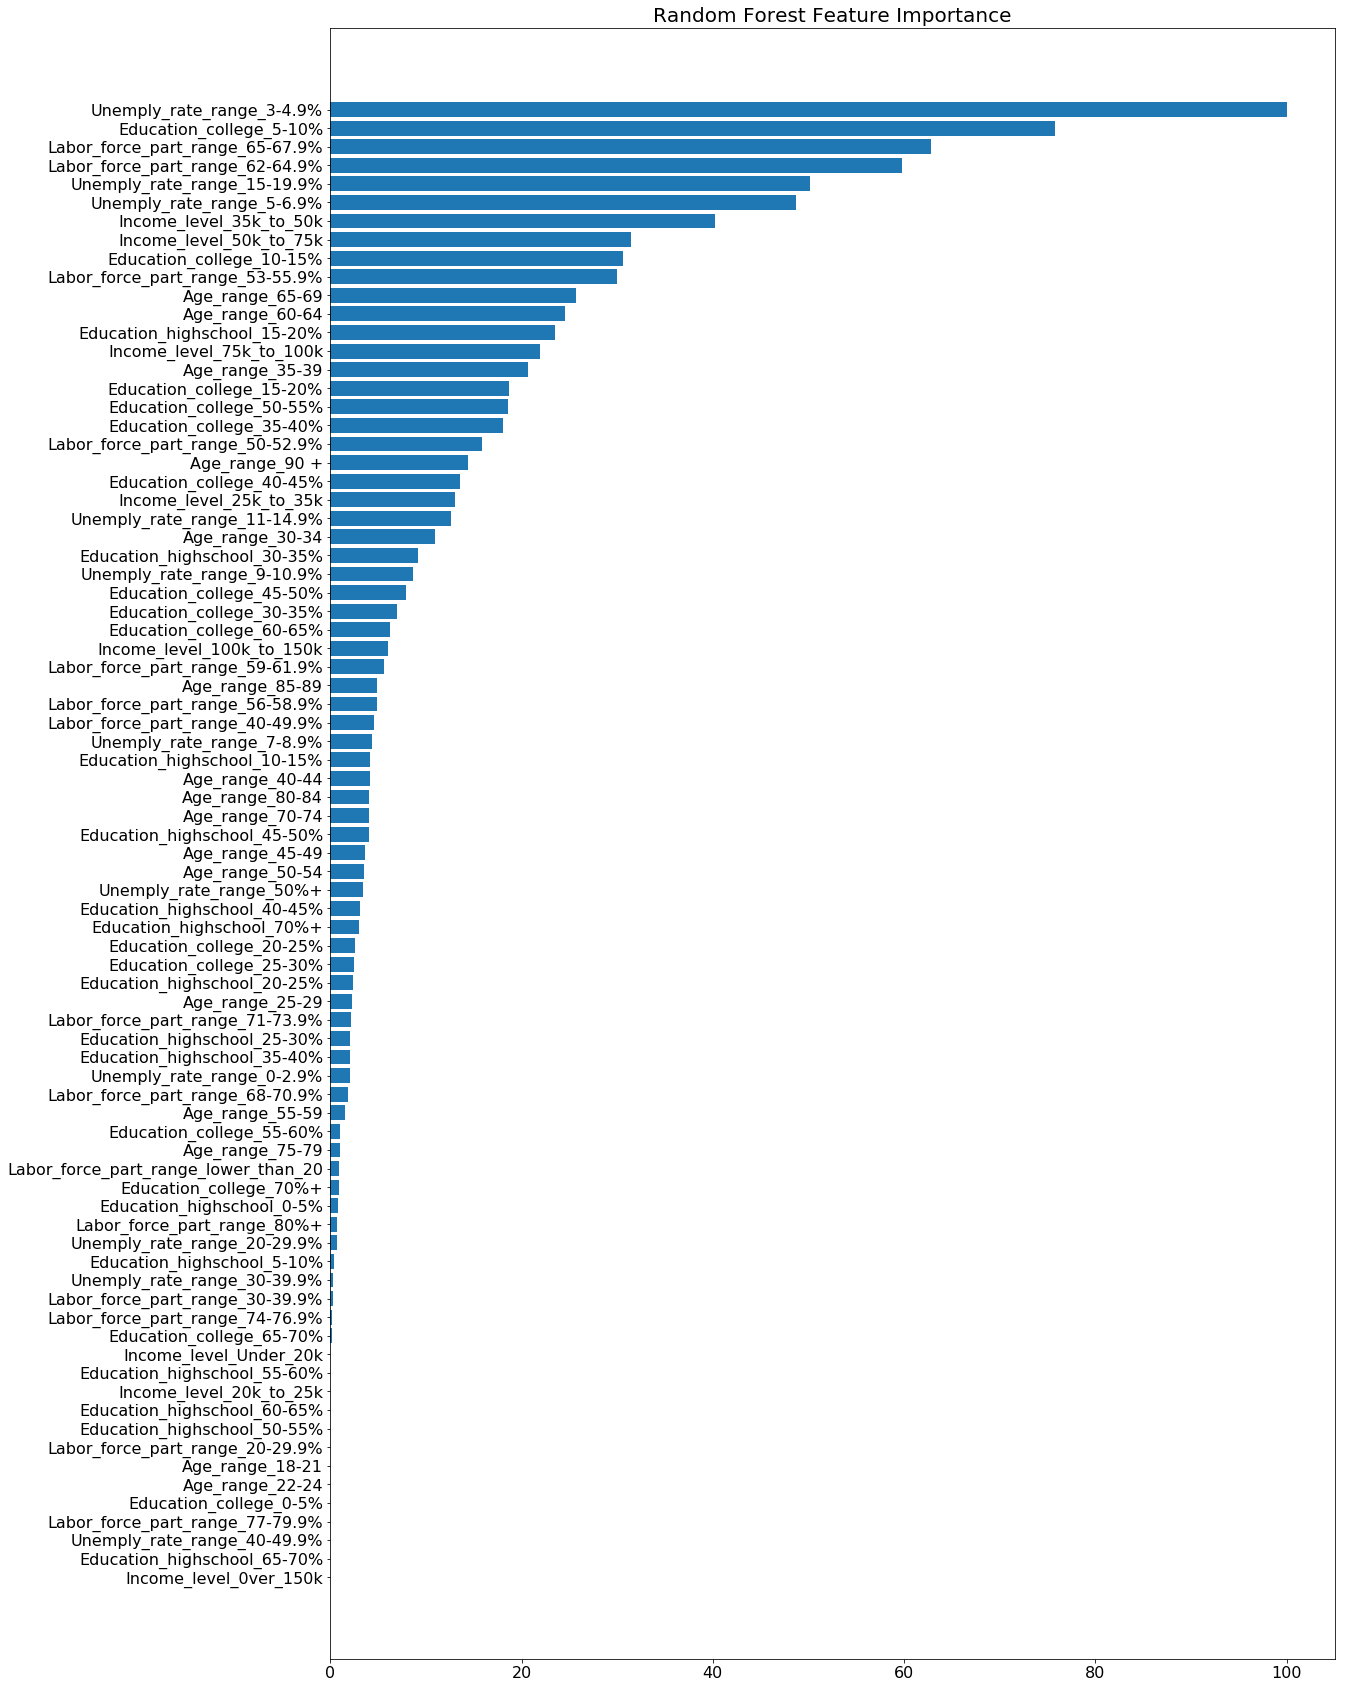

In [82]:
plt.figure(figsize=(18,30))
plt.barh(random.features, random.coef)
plt.title('Random Forest Feature Importance', fontsize=20)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16);

plt.savefig('RF_feature_importance.png')

# SMOTE Model 

In [55]:
from imblearn.over_sampling import SMOTE 

In [56]:
X_smote, y_smote = SMOTE().fit_sample(X_train, y_train)

In [57]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, random_state= 10, test_size=0.3)

In [58]:
pipe_rf = Pipeline([('pca', PCA(n_components=20, random_state=42)), 
                   ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

s_pipelines =  [pipe_rf]
s_names = ['Random Forest']
s_pipe_Model = []

# loop to fit each of the three pipelines
for i in s_pipelines: 
    print(i)
    i.fit(X_train_smote, y_train_smote)
    
for index, val in enumerate(s_pipelines): 
    print('%s pipeline train accuracy: %.3f' % (s_names[index], val.score(X_train_smote, y_train_smote)))
    print('%s pipeline test accuracy: %.3f' % (s_names[index], val.score(X_test_smote, y_test_smote)))
    
    score = s_names[index], val.score(X_train_smote, y_train_smote), val.score(X_test_smote, y_test_smote), 
    s_pipe_Model.append(score)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=20, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            m...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
Random Forest pipeline train accuracy: 0.596
Random Forest pipeline test accuracy: 0.567


In [60]:
s_model = pd.DataFrame.from_records(s_pipe_Model,  columns=['SMOTE Model', 'Train', 'Test'])
s_model

,SMOTE Model,Train,Test
0,Random Forest,0.595541,0.566852


In [61]:
#printing our classification report for all models
for index, val in enumerate(s_pipelines):
    print(f'{s_names[index]}:')
    print(classification_report(y_test, val.predict(X_test)))
    print('--------------------------------------------------------')

Random Forest:
              precision    recall  f1-score   support

           0       0.56      0.33      0.41      1486
           1       0.53      0.74      0.62      1514

   micro avg       0.54      0.54      0.54      3000
   macro avg       0.54      0.54      0.52      3000
weighted avg       0.54      0.54      0.52      3000

--------------------------------------------------------


# Feature Importance 

In [62]:
s_rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
s_rf.fit(X_train_smote, y_train_smote);

In [63]:
s_rf_imp = s_rf.feature_importances_

In [64]:
s_rf_list = []

for name, importance in zip(features, 100*(s_rf_imp/ s_rf_imp.max())):
    print(name, '=', importance)
    s_rf_list.append(importance)

Income_level_0ver_150k = 0.0
Income_level_100k_to_150k = 1.681418750929239
Income_level_20k_to_25k = 0.0
Income_level_25k_to_35k = 24.096495975128253
Income_level_35k_to_50k = 33.58434788273355
Income_level_50k_to_75k = 22.899525210998902
Income_level_75k_to_100k = 44.355277477009054
Income_level_Under_20k = 0.0
Age_range_18-21 = 0.0
Age_range_22-24 = 0.0
Age_range_25-29 = 3.972766491712558
Age_range_30-34 = 11.48045979608332
Age_range_35-39 = 31.40241797343351
Age_range_40-44 = 8.925937031123482
Age_range_45-49 = 24.717505084087566
Age_range_50-54 = 6.4705807674284435
Age_range_55-59 = 3.511557754687844
Age_range_60-64 = 44.48281628888015
Age_range_65-69 = 13.568048535962888
Age_range_70-74 = 3.8239596046921385
Age_range_75-79 = 0.9008023502355926
Age_range_80-84 = 3.781774704599303
Age_range_85-89 = 0.8016020752443641
Age_range_90 + = 6.189034881032393
Unemply_rate_range_0-2.9% = 3.0515991537249096
Unemply_rate_range_11-14.9% = 44.36675271380907
Unemply_rate_range_15-19.9% = 28.68293

In [65]:
s_ft = pd.DataFrame(features.columns)
s_forest = pd.DataFrame(rf_list) 

s_random = pd.concat([ft, forest],axis=1)
s_random.columns = ['features', 'coef']
s_random = random.sort_values('coef', ascending=True)

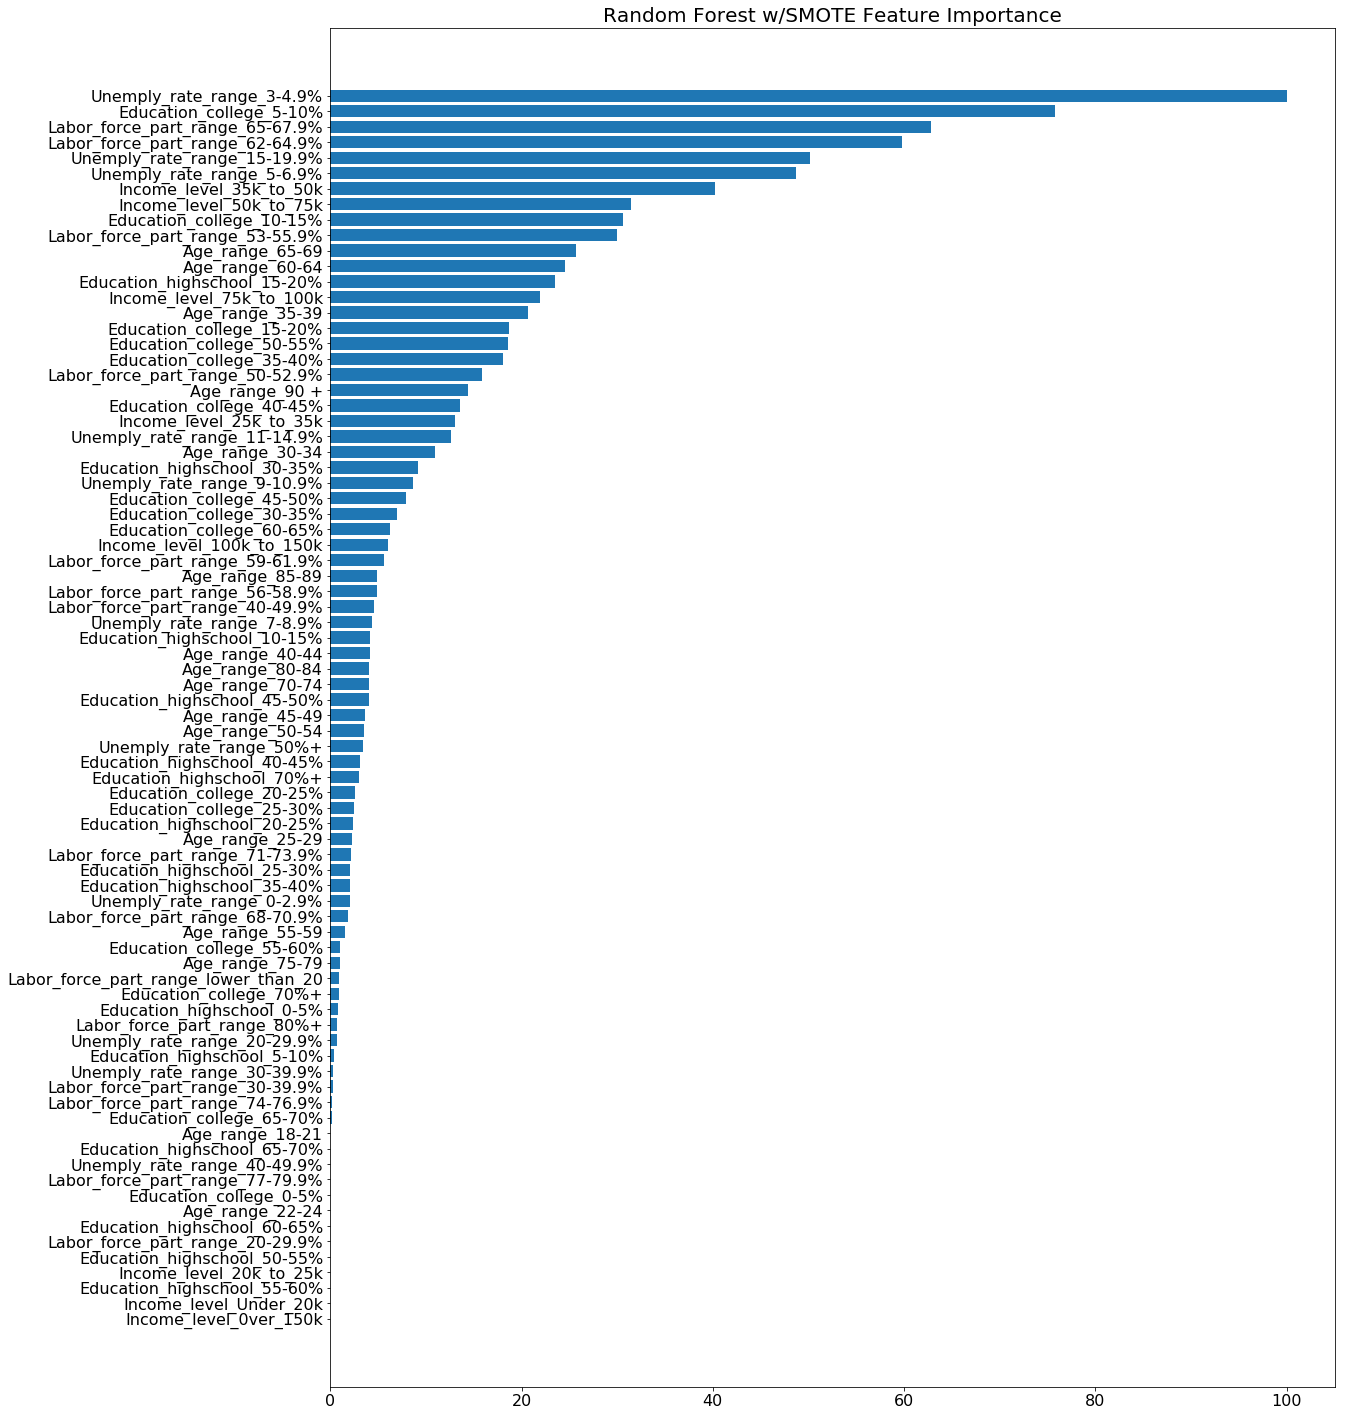

In [76]:
plt.figure(figsize=(18,25))
plt.barh(s_random.features, s_random.coef)
plt.title('Random Forest w/SMOTE Feature Importance', fontsize=20)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16);

In [67]:
feature_importance_df = s_random.sort_values('coef', ascending=False)

In [72]:
feature_importance_df.reset_index(inplace=True)

In [75]:
feature_importance_df.to_csv('feature_importance.csv', index=False)

In [78]:
feature_importance_df['score'] = round(feature_importance_df.coef * .1, 2)

In [80]:
feature_importance_df.to_csv('scoring.csv', index= False)

In [81]:
feature_importance_df

,features,coef,score
0,Unemply_rate_range_3-4.9%,100.000000,10.00
1,Education_college_5-10%,75.785412,7.58
2,Labor_force_part_range_65-67.9%,62.804691,6.28
3,Labor_force_part_range_62-64.9%,59.753178,5.98
4,Unemply_rate_range_15-19.9%,50.139749,5.01
5,Unemply_rate_range_5-6.9%,48.656659,4.87
6,Income_level_35k_to_50k,40.201833,4.02
7,Income_level_50k_to_75k,31.495718,3.15
8,Education_college_10-15%,30.632228,3.06
9,Labor_force_part_range_53-55.9%,29.959028,3.00
